# Measuring $T_2$ 

Measuring the $T_2$ lifetime of qubits is an interesting experiment to run on a quantum computer to know more about its qubits performance.

In this notebook, you will ...
* ... understand how to measure the $T_2$ time and why this is an important quantity to know about your quantum computer.

By the end of this notebook, you will not only have a basic understanding of how to execute pulse schedules, but you will also have a feeling for the outcome to expect in your experiments.

In [17]:
import os
import numpy as np
from iqm.pulla.pulla import Pulla
from iqm.pulse import Circuit
from iqm.pulse import CircuitOperation as Op
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML

## Setup IQM server

In the following, we will use the PulLa (Pulse Level Access) package. You can find the documentation [here](https://docs.meetiqm.com/iqm-pulla/).

As a first step, we need to create a **PulLa object**. In general, this is a **compiler**, in a particular state, linked to a particular quantum computer. It contains calibration data and the set of available operations. 

Make sure you have the correct url and token below.

In [18]:
token = os.getenv("IQM_TOKEN")
os.environ["IQM_TOKEN"] = token
server_url = "https://resonance.meetiqm.com/sirius"
p = Pulla(server_url)
compiler = p.get_standard_compiler()

## Measuring the $T_2$ time

The **decoherence** $T_2$ time of a qubit is a crucial parameter in the field of quantum computing. The decoherence process is driven by the qubit's interaction with its surrounding environment. The noise influencing the qubit's dynamics can be due to various environmental factors, such as thermal fluctuations, electromagnetic fields or material defects.
In quantum computing, the $T_2$ time sets a practical limit on the duration for which a qubit can reliably store quantum coherence. The longer the $T_2$ time, the better the qubit is at preserving the integrity of its quantum state against a **combination of energy relaxation and dephasing**, thereby enhancing the potential for performing more advanced quantum algorithms. This is why the errors caused by decoherence have to be carefully taken into account in any realistic noise model of NISQ devices and why $T_2$ is important for performance benchmarking.

The $T_2$ time describes the loss of coherence of a **superposition state**, which after complete decoherence becomes a maximally mixed state. Experimentally, $T_2$ can be measured by performing the following steps:

- Prepare the qubit in a state on the xy-plane
- Wait some time
- Apply a X180 gate, - i.e. a $R_x(\pi)$
- Wait some time
- Project back on to the z-axis
- Measure

The $R_x(\pi)$ operation between the two delays of time allows us to partially mitigate the effect of noise contributing to dephasing, giving a more accurate estimation of the qubit's decay time $T_2$. This is called the **Hahn Echo experiment**. Repeating the preparation, waiting and measurement process several times, we can estimate the probability to measure the ground state. If we assume that there are no preparation and measurement errors (the so-called SPAM errors), then the decay of this probability $p$ is exponential and characterized by $p(t)=e^{-t/T_2}$.

As outlined above, we measure the qubit after **different fixed delays of time**. During these delays, the Bloch vector representing the qubit precesses around the z-axis when the frequency of the control pulse is detuned from the qubit frequency. As a consequence, we see oscillations in the measured probabilities of finding the qubit in the excited or ground state. This *detuning* of frequencies can be observed in the so-called **Ramsey experiment**, which also gives an approximation for the decoherence time, often indicated with $T_2^*$. In this case, the qubit is not "refocused", so the value of $T_2^*$ is very sensitive to the noise components contributing to dephasing.

To start our $T_2$ experiment, we need to create a custom **Wait** operation that can be add to our circuit before measuring (i.e. an additional **compilation stage**):

Then we register the operation we created above so that the compiler knows what to do when it encounters a 'Wait':

### Echo Hahn experiment
We create a circuit for each delay of time that we want to measure (time axis below). 

In each circuit, we apply a $R_x(\pi/2)$, our custom 'Wait' operation, the 'refocus' operation $R_x(\pi)$, again the custom 'Wait' operation, finally a $R_x(\pi/2)$ and we measure the qubit.

In [19]:
qubits = compiler.builder.chip_topology.qubits_sorted
qubits = qubits[0:2]

time_axis = np.linspace(0.0, 300e-6, 51) # In seconds
circuits = []
for wait_time in time_axis:
    
    instructions=[]
    for qubit in qubits:
        instructions += [
            Op("prx", (qubit,), args={"angle": np.pi/2, "phase": 0.0}),
            Op("delay", (qubit,), args={"duration": wait_time/2}),
            Op("prx", (qubit,), args={"angle": np.pi, "phase": 0.0}),
            Op("delay", (qubit,), args={"duration": wait_time/2}),
            Op("prx", (qubit,), args={"angle": np.pi/2, "phase": 0.0}),
        ]                                 
    instructions.append(Op("measure", qubits, args={"key": "M"}))
    circuits.append(Circuit("T2", tuple(instructions)))

We tweak the settings so that the shots used in the measurement are averaged by the server and we don't need to do it ourselves.
The results are therefore returned as sampled probabilities.

We are now ready to compile the circuits and run the experiment!

In [20]:
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=500)
settings.options.averaging_bins = 1  
job = p.submit_playlist(playlist, settings, context=context)
job.wait_for_completion()

[01-20 18:27:16;I] Submitted a job with ID: 019bdc72-4ce1-7d62-af5c-bf7f87a4d909
[01-20 18:27:16;I] Waiting for job 019bdc72-4ce1-7d62-af5c-bf7f87a4d909 to finish...


Progress in queue:   0%|                                                                                     | 0/1 [00:20<?, ?it/s]


<JobStatus.COMPLETED: 'completed'>

### Analyze the results

Now that the 'playist' above has successfully run, we can plot the probability data and observe the exponential decay behavior. We fit the data to an exponential decay curve and extract the $T_2$ time. Even though the theoretical result tells us that $p$ decays as $e^{-t/T_2}$, in reality SPAM errors exist and we need to take them into account. To this end, we write the exponential function in its most general form $A e^{-x/B}+C$ such that the additional parameters can help us accomodate for differences with the theoretical results due to SPAM errors.

QB1 T2 (echo) =  21.5 µs
QB2 T2 (echo) =  27.0 µs


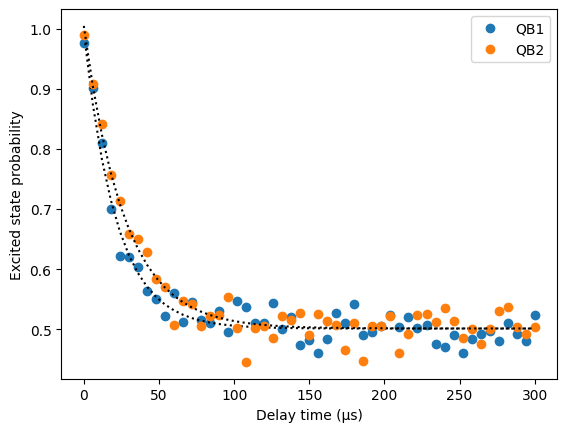

In [21]:
def exp_func(x, a, b, c):
    return a * np.exp(- x / b) + c

x = time_axis * 1e6

for i, qubit in enumerate(qubits):
    
    y = np.array([1-circuit_result["M"][0][i] for circuit_result in job.result()])
    popt, _ = curve_fit(exp_func, time_axis, y, p0=[1,50e-6,0])  
    print(f"{qubit} T2 (echo) = {popt[1]*1e6 : .1f} µs", )
    
    plt.plot(x, y, 'o', label=qubit)
    plt.plot(x, exp_func(np.array(time_axis), *popt), 'k:')
    
plt.xlabel("Delay time (µs)")
plt.ylabel("Excited state probability")
plt.legend();
plt.show()

## Visualization 
We can also visualise the final playlist. We should see that each circuit is different and the 'Wait' are increasing in length towards the end.

In [ ]:
HTML(inspect_playlist(playlist, range(5))) # Show first 5 circuits

In [1]:
# Copyright 2025 IQM Quantum Computers (Joni Ikonen, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.